## 11/13 Notebook to be converted to a script to run tests of mpasregions package
### This notebook is used to test the transect sorting algorithms. This requires consideration for transects created from algorithms and for transects created form an initial geojson mask file. 

In [227]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [228]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools

from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import geojson
import json
import mosaic
import os.path
import mpasregions.sections as mps
import gsw
import warnings 
import glob
from xgcm import Grid

### create dataset

In [229]:
# I actually think that you will need to somehow define cells to be nans to represent land (or at least for cellsOnEdge)... 
# And then you remove the edges and vertices that would be captured within those cells...? 

lonCells = np.array([180.,  90., 270.])
latCells = np.array([-36.,  36.,  36.])

lonEdges = np.array([135., 235.,  90., 270.,  45., 135., 225., 315.,   0., 180., 45., 135., 225., 315.])
latEdges = np.array([-72., -72., -36., -36.,   0.,   0.,   0.,   0.,  36.,  36., 72.,  72.,  72.,  72.])

lonVertices = np.array([180.,  90., 270.,  90., 270.,   0., 180.,   0., 180., 90., 270.])
latVertices = np.array([-90., -54., -54., -18., -18.,  18.,  18.,  54.,  54., 90.,  90.])

ds = xr.Dataset({},coords={
    'nCells':xr.DataArray(np.arange(0,len(lonCells)), dims='nCells'),
    'nEdges': xr.DataArray(np.arange(0,len(lonEdges)), dims='nEdges'),
    'nVertices':xr.DataArray(np.arange(0,len(lonVertices)), dims='nVertices')
})

ds['lonCell'] = xr.DataArray(np.deg2rad(lonCells), dims='nCells')
ds['latCell'] = xr.DataArray(np.deg2rad(latCells), dims='nCells')
ds['lonEdge'] = xr.DataArray(np.deg2rad(lonEdges), dims='nEdges')
ds['latEdge'] = xr.DataArray(np.deg2rad(latEdges), dims='nEdges')
ds['lonVertex'] = xr.DataArray(np.deg2rad(lonVertices), dims='nVertices')
ds['latVertex'] = xr.DataArray(np.deg2rad(latVertices), dims='nVertices')

xr_edgesOnVertex =  np.array([
    [0,1,np.nan], # on vertex 0
    [0,2,np.nan], # on vertex 1
    [1,3,np.nan], # on vertex 2
    [2,4,5], # on vertex 3
    [3,6,7], # on vertex 4
    [4,7,8], # on vertex 5
    [5,6,9], # on vertex 6
    [8,10,13], # on vertex 7
    [9,11,12], # on vertex 8
    [10,11,np.nan], # on vertex 9
    [12,13,np.nan] # on vertex 10
])

n_edgesOnVertex = mps.xr_to_n_idx(xr_edgesOnVertex)
n_edgesOnVertex[np.isnan(n_edgesOnVertex)] = 0 # extra vertices that were once nans are now zeros

ds['edgesOnVertex'] = xr.DataArray(np.int32(n_edgesOnVertex), dims = ('nVertices','vertexDegree'))
# ds['edgesOnVertex'] = ds.edgesOnVertex.where(ds.edgesOnVertex > 0)
# ds.edgesOnVertex

xr_verticesOnEdge = np.array([
    [0,1], # on edge 0
    [0,2], # on edge 1
    [1,3], # on edge 2
    [2,4], # on edge 3
    [3,5], # on edge 4
    [3,6], # on edge 5
    [4,6], # on edge 6
    [4,5], # on edge 7
    [5,7], # on edge 8
    [6,8], # on edge 9
    [7,9], # on edge 10
    [8,9], # on edge 11
    [8,10], # on edge 12
    [7,10] # on edge 13
    
])

n_verticesOnEdge = mps.xr_to_n_idx(xr_verticesOnEdge)
ds['verticesOnEdge'] = xr.DataArray(np.int32(n_verticesOnEdge), dims=('nEdges', 'TWO'))

xr_cellsOnEdge = np.array([
    [0,np.nan], # on edge 0
    [0,np.nan], # on edge 1
    [0,np.nan], # on edge 2
    [0,np.nan], # on edge 3
    [1,np.nan], # on edge 4
    [0,1],  # on edge 5
    [0,2],  # on edge 6
    [2,np.nan], # on edge 7
    [1,2],  # on edge 8
    [1,2],  # on edge 9
    [1,np.nan], # on edge 10
    [1,np.nan], # on edge 11
    [2,np.nan], # on edge 12
    [2,np.nan] #on edge 13
])

n_cellsOnEdge = mps.xr_to_n_idx(xr_cellsOnEdge)
n_cellsOnEdge[np.isnan(n_cellsOnEdge)] = 0
ds['cellsOnEdge'] = xr.DataArray(np.int32(n_cellsOnEdge), dims=('nEdges', 'TWO'))

xr_verticesOnCell = np.array([
                    [0,1,3,6,4,2,np.nan], # on cell 0
                    [3,5,7,9,8,6,np.nan], # on cell 1
                    [4,6,8,10,7,5,np.nan] # on cell 2
])

n_verticesOnCell = mps.xr_to_n_idx(xr_verticesOnCell)
n_verticesOnCell[np.isnan(n_verticesOnCell)] = 0
ds['verticesOnCell'] = xr.DataArray(np.int32(n_verticesOnCell), dims=('nCells','maxEdges'))

xr_edgesOnCell = np.array([
                [0,2,5,6,3,1,np.nan], # on cell 0
                [4,8,10,11,9,5,np.nan], # on cell 1
                [6,9,12,13,8,7,np.nan] # on cell 2
])

n_edgesOnCell = mps.xr_to_n_idx(xr_edgesOnCell)
n_edgesOnCell[np.isnan(n_edgesOnCell)] = 0
ds['edgesOnCell'] = xr.DataArray(np.int32(n_edgesOnCell), dims=('nCells','maxEdges'))

ds['VertexID'] = mps.xr_to_n_idx(ds.nVertices)
ds = ds.assign_coords({'VertexID': mps.xr_to_n_idx(ds.nVertices)})

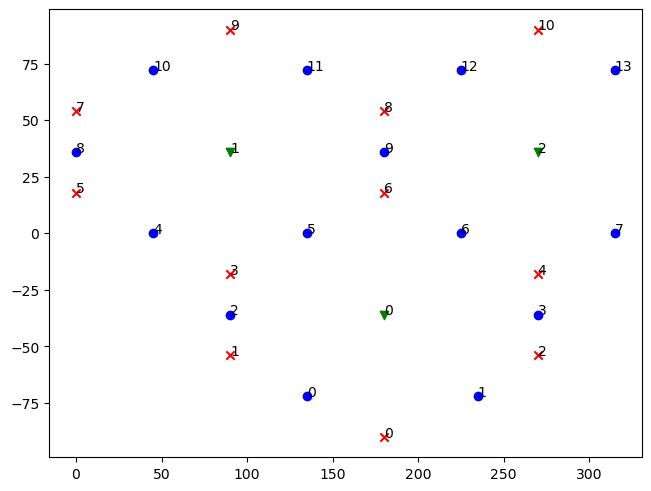

In [230]:
fig,ax=plt.subplots(nrows=1,ncols=1,constrained_layout=True)
ax.scatter(np.rad2deg(ds.lonEdge),np.rad2deg(ds.latEdge),color='blue')
ax.scatter(np.rad2deg(ds.lonVertex),np.rad2deg(ds.latVertex),marker='x',color='red')
ax.scatter(np.rad2deg(ds.lonCell), np.rad2deg(ds.latCell),marker='v',color='green')
nEdges = ds.nEdges.values
nVertices = ds.nVertices.values
nCells = ds.nCells.values

for i, txt in enumerate(nEdges):
    ax.annotate(txt, (np.rad2deg(ds.lonEdge[i]),np.rad2deg(ds.latEdge[i])))

for i, txt in enumerate(nVertices):
    ax.annotate(txt, (np.rad2deg(ds.lonVertex[i]), np.rad2deg(ds.latVertex[i])))

for i, txt in enumerate(nCells):
    ax.annotate(txt, (np.rad2deg(ds.lonCell[i]), np.rad2deg(ds.latCell[i])))

## create mask from data...

In [232]:
# TESTS SORTING ALGORITHMS FOR TRANSECTS CREATED FROM MASKS & FOR TRANSECTS CREATED FROM ALGORITHM THAT MAY DOUBLE-COUNT VERTICES
# def sorted_transect_edges_and_vertices(ds, xr_mask_transect_edges, xr_mask_transect_vertices)
# def find_transect_edges_and_vertices(ds, mask)
def test_sorted_transect_edges_and_vertices():
    from mpasregions.sections import sorted_transect_edges_and_vertices
    # shuffle the vertices and edges of a closed-loop transect
    xr_mask_transect_edges_shuffled = np.array([11,8,5,9,10,4])
    xr_mask_transect_vertices_shuffled = np.array([5,8,7,3,6,9])

    sorted_edges, sorted_vertices = sorted_transect_edges_and_vertices(ds, xr_mask_transect_edges_shuffled, xr_mask_transect_vertices_shuffled)
    

In [233]:
def test_sorted_transect_edges_and_vertices():
    from mpasregions.sections import sorted_transect_edges_and_vertices
    # shuffle the vertices and edges of a closed-loop transect
    xr_mask_transect_edges_shuffled = np.array([11,8,5,9,10,4])
    xr_mask_transect_vertices_shuffled = np.array([5,8,7,3,6,9])

    sorted_edges, sorted_vertices = sorted_transect_edges_and_vertices(ds, xr_mask_transect_edges_shuffled, xr_mask_transect_vertices_shuffled)
    return sorted_edges, sorted_vertices

In [234]:
sorted_edges, sorted_vertices = test_sorted_transect_edges_and_vertices()

In [235]:
sorted_edges

array([11,  9,  5,  4,  8, 10, 11], dtype=int32)

In [236]:
sorted_vertices

array([8, 6, 3, 5, 7, 9, 8], dtype=int32)

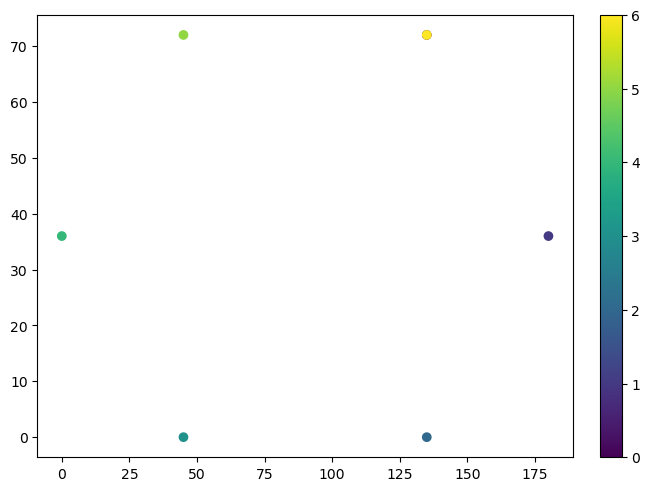

In [237]:
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)

deg_edge_lons = np.rad2deg(ds.lonEdge.isel(nEdges = sorted_edges))
deg_edge_lats = np.rad2deg(ds.latEdge.isel(nEdges = sorted_edges))

a = ax.scatter(deg_edge_lons, deg_edge_lats,c=np.arange(0,len(sorted_edges)))
fig.colorbar(a)

In [238]:
# test if basic algorithm works
target_lons = np.array([90,90,180])
target_lats = np.array([-18,90,18])
test_edges, test_vertices = mps.calculate_transects_multiple_pts(target_lons, target_lats, ds)

xr_end_vertex is  9
broken because reached end vertex
xr_end_vertex is  6
broken because reached end vertex
xr_end_vertex is  3
broken because reached end vertex


In [239]:
# test if basic algorithm works to create a bad mask
# we want a mask that will cross over itself
## this set doesn't work, which is what you should use to test it
target_lons = np.array([90,180,180,270,180,75,0])
target_lats = np.array([75,60,25,-25,25,-25,25])

# ## but first test this set, which travels to one point further??
# target_lons = np.array([180,180,270,270,180,75,0])
# target_lats = np.array([60,25,-25,-50,25,-25,25])

test_edges, test_vertices = mps.calculate_transects_multiple_pts(target_lons, target_lats, ds)

# now you have to create a .nc file and mask
path = './'
filename = 'test2'
geojson_file_name = 'test from transect algorithm'
tags = "Labrador_Sea;Davis_Strait"
author = "Kaila Uyeda"
test_verts_lats, test_verts_lons, dsMasks = mps.transect_from_alg_create_nc(test_vertices, 
                                                                            ds,
                                                                            path,
                                                                            filename,
                                                                            geojson_file_name,
                                                                            tags,
                                                                            author)


xr_end_vertex is  8
broken because reached end vertex
xr_end_vertex is  6
broken because reached end vertex
xr_end_vertex is  4
broken because reached end vertex
xr_end_vertex is  6
broken because reached end vertex
xr_end_vertex is  3
broken because reached end vertex
xr_end_vertex is  5
broken because reached end vertex
xr_end_vertex is  9
broken because reached end vertex
test2_transect_from_alg.geojson exists!
Opening test2_transect_from_alg.nc as dsMasks


In [270]:
transect_edges, transect_vertices = mps.find_transect_edges_and_vertices(ds,dsMasks)

In [241]:
# then you have to sort these vertices
sorted_edges, sorted_vertices = mps.sorted_transect_edges_and_vertices(ds, transect_edges, transect_vertices)

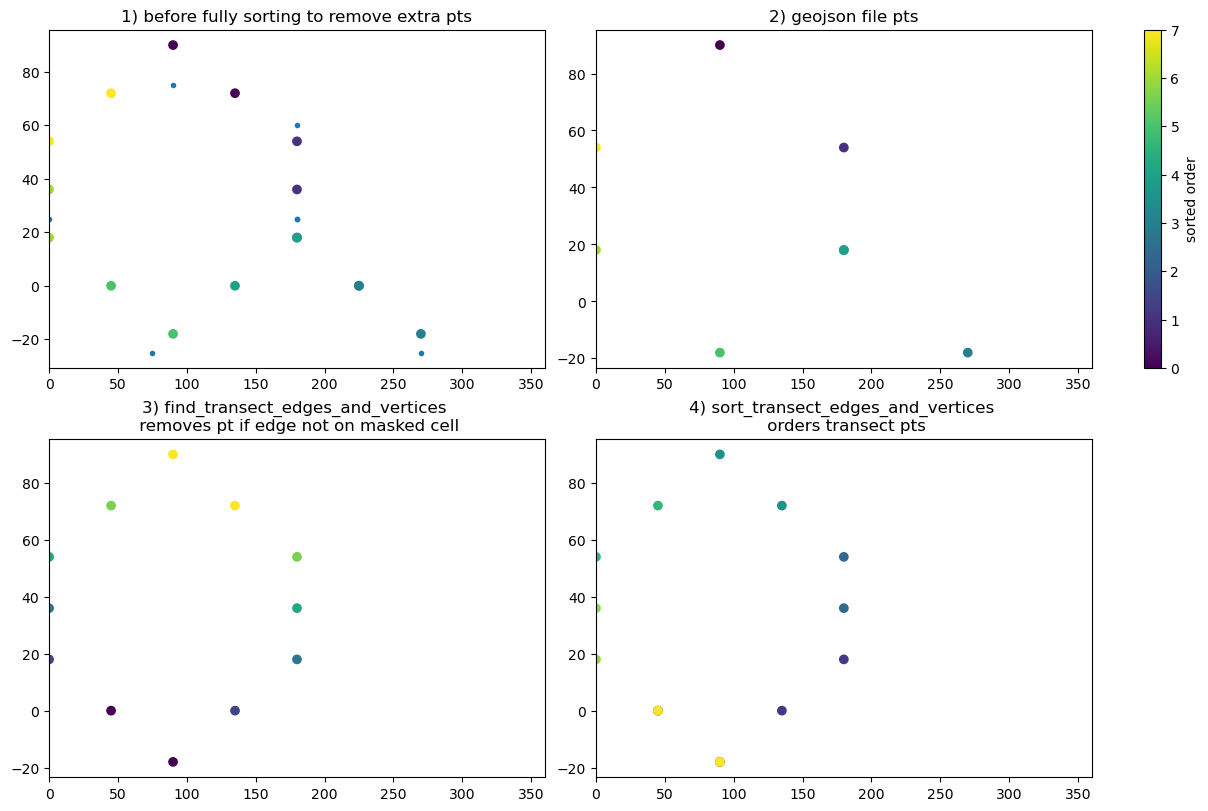

In [279]:
fig,ax = plt.subplots(nrows=2,ncols=2, constrained_layout=True,figsize=(12,8))
ax[0,0].scatter(target_lons,target_lats,marker='.',label='target start/end pts')
ax[0,0].scatter(np.rad2deg(ds.lonVertex.isel(nVertices = test_vertices)),np.rad2deg(ds.latVertex.isel(nVertices = test_vertices)), c=np.arange(0,len(test_vertices)),label='sorted vertices')
a=ax[0,0].scatter(np.rad2deg(ds.lonEdge.isel(nEdges = test_edges)),np.rad2deg(ds.latEdge.isel(nEdges = test_edges)),c=np.arange(0,len(test_edges)),
           label='sorted edges')
ax[0,0].set_title('1) before fully sorting to remove extra pts')
fig.colorbar(a,ax=ax[0],label='sorted order')

ax[0,1].scatter(test_verts_lons,test_verts_lats,c=np.arange(0,len(test_verts_lats)))
ax[0,1].set_title('2) geojson file pts')

ax[1,0].scatter(np.rad2deg(ds.lonVertex.isel(nVertices = transect_vertices)), np.rad2deg(ds.latVertex.isel(nVertices = transect_vertices)), c=np.arange(0,len(transect_vertices)),label='found vertices')
ax[1,0].scatter(np.rad2deg(ds.lonEdge.isel(nEdges = transect_edges)), np.rad2deg(ds.latEdge.isel(nEdges = transect_edges)), c=np.arange(0,len(transect_edges)),label='found edges')
ax[1,0].set_title('3) find_transect_edges_and_vertices \n removes pt if edge not on masked cell')

ax[1,1].scatter(np.rad2deg(ds.lonVertex.isel(nVertices = sorted_vertices)),np.rad2deg(ds.latVertex.isel(nVertices = sorted_vertices)), c=np.arange(0,len(sorted_vertices)),label='sorted vertices')
ax[1,1].scatter(np.rad2deg(ds.lonEdge.isel(nEdges = sorted_edges)),np.rad2deg(ds.latEdge.isel(nEdges=sorted_edges)), c=np.arange(0,len(sorted_edges)), label='sorted edges')
ax[1,1].set_title('4) sort_transect_edges_and_vertices \n orders transect pts')

for i in range(0,2):
    for j in range(0,2):
        ax[i,j].set_xlim(0,360)

In [242]:
next_edges, next_vertices = mps.find_and_sort_transect_edges_and_vertices(ds,dsMasks)

# next_edges should equal sorted_edges
# next_vertices shoudl equal sorted_vertices

In [243]:
next_edges - sorted_edges

array([0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [244]:
next_vertices - sorted_vertices

array([0, 0, 0, 0, 0, 0, 0], dtype=int32)